In [324]:
%pip install torch

python(18715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [326]:
### --- QUESTION 1 ----

In [59]:
titanic = pd.read_csv('/Users/giovannimaya/Downloads/TitanicSurvival.csv')
titanic.head()


,rownames,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
1,"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
2,"Allison, Miss. Helen Loraine",no,female,2.0000,1st
3,"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
4,"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


In [60]:
from sklearn.preprocessing import LabelEncoder
titanic['age'].fillna(titanic['age'].mean(), inplace=True)
sex_encoder = LabelEncoder()
survived_encoder = LabelEncoder()
passenger_encoder = LabelEncoder()
titanic['survived'] = survived_encoder.fit_transform(titanic['survived'])
titanic['passengerClass'] = passenger_encoder.fit_transform(titanic['passengerClass'])
titanic['sex'] = sex_encoder.fit_transform(titanic['sex'])
titanic.head()

,rownames,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",1,0,29.0000,0
1,"Allison, Master. Hudson Trevor",1,1,0.9167,0
2,"Allison, Miss. Helen Loraine",0,0,2.0000,0
3,"Allison, Mr. Hudson Joshua Crei",0,1,30.0000,0
4,"Allison, Mrs. Hudson J C (Bessi",0,0,25.0000,0


In [62]:
## centering for q1 part A
predictors = ['sex', 'age', 'passengerClass']
titanic[predictors] = titanic[predictors].apply(lambda x: (x - x.mean()) / x.std())
feats = torch.tensor(titanic[predictors].values, dtype=torch.float)
target = torch.tensor(titanic['survived'].values, dtype=torch.float)
target.shape, feats.shape
titanic[predictors].head()

## end of part a 

,sex,age,passengerClass
0,-1.344482,-0.068394,-1.545507
1,0.743213,-2.248233,-1.545507
2,-1.344482,-2.164147,-1.545507
3,0.743213,0.009226,-1.545507
4,-1.344482,-0.378876,-1.545507


In [330]:
## start of part b 


In [80]:
from torch import Tensor
def forward_pass(feats: Tensor, weights: int) -> Tensor:
    z = torch.matmul(feats, weights)
    return 1 / (1 + torch.exp(-z))

weights = torch.randn(3, 1, dtype=torch.float, requires_grad=True)
print(titanic.iloc[0][predictors])
stand_input = torch.tensor(titanic.iloc[0][predictors], dtype=torch.float)
prob = forward_pass(stand_input, weights)
print(prob.item())

sex              -1.344482
age              -0.068394
passengerClass   -1.545507
Name: 0, dtype: object
0.44657179713249207


/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_7624/625847970.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stand_input = torch.tensor(titanic.iloc[0][predictors], dtype=torch.float)


In [81]:
def cross_entropy_loss(predict: Tensor, targets: Tensor) -> Tensor:
    epsilon = 1e-6
    return -torch.mean(targets * torch.log(predict + epsilon) + (1 - targets) * torch.log(1 - predict + epsilon))
target = torch.tensor([[1.0]])
loss = cross_entropy_loss(prob, target)
print(loss.item())

0.8061528205871582


In [65]:
print(loss.backward())
print("Gradients of the weights:", weights.grad)

None
Gradients of the weights: tensor([[1.0342],
        [0.0526],
        [1.1888]])


In [334]:
## end of c both parts 

[[682 127]
 [160 340]]
Training completed for learning rate: 0.01
[[282 527]
 [231 269]]
Training completed for learning rate: 0.001
[[658 151]
 [157 343]]
Training completed for learning rate: 0.0001
[[249 560]
 [332 168]]
Training completed for learning rate: 1e-05
[[355 454]
 [203 297]]
Training completed for learning rate: 1e-06


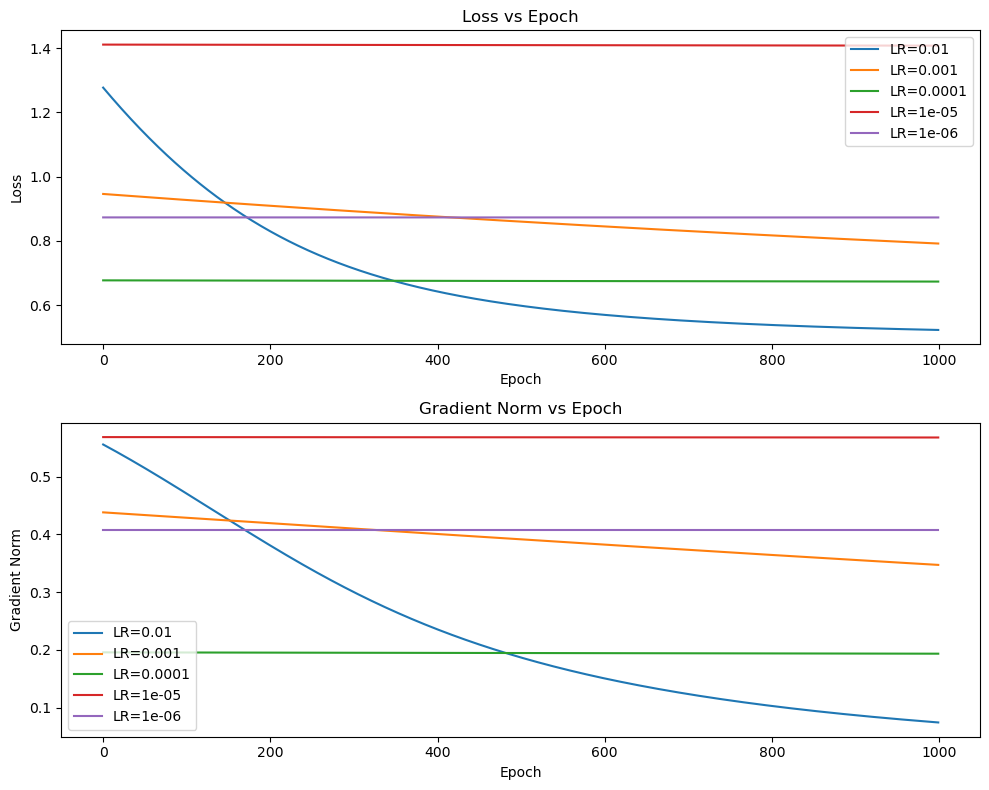

In [119]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch import Tensor

def train_model(X: Tensor, y: Tensor, learning_rates, epochs=1000):
    metrics = {}
    confusion_matrices = []
    for lr in learning_rates:
        weights = torch.randn(3, requires_grad=True)
        
        losses = []
        gradient_history = []
        
        for epoch in range(epochs):
            y_hat = forward_pass(X, weights)   # forward pass -> current prediction
            loss = cross_entropy_loss(y_hat, y) # calculate loss
            losses.append(loss.item())
            loss.backward()      # backward pass -> calculate gradient
            
            with torch.no_grad():  
                weights -= lr * weights.grad # update weight using gradient descent
                gradient_history.append(weights.grad.norm().item())  # store gradient norm
            weights.grad.zero_()

        final_predictions = forward_pass(X, weights)
        predicted_classes = torch.round(final_predictions).detach()
        metrics[lr] = (losses, gradient_history)
        
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(y.detach().numpy(), predicted_classes.numpy())
        confusion_matrices.append((conf_matrix, lr))
        print(conf_matrix)
        print(f"Training completed for learning rate: {lr}")
    
    return weights, metrics, confusion_matrices

# Assuming feats and titanic['survived'] are defined elsewhere in your code.
target = torch.tensor(titanic['survived'].values, dtype=torch.float)
learning_rates = [1e-5]
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
final_weights, training_metrics, confusion_metrics = train_model(feats, target, learning_rates)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for lr, (losses, gradients) in training_metrics.items():
    ax[0].plot(losses, label=f"LR={lr}")
    ax[1].plot(gradients, label=f"LR={lr}")

ax[0].set_title('Loss vs Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Gradient Norm vs Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Gradient Norm')
ax[1].legend()

plt.tight_layout()
plt.show()


[(array([[682, 127],
       [160, 340]]), 0.01), (array([[282, 527],
       [231, 269]]), 0.001), (array([[658, 151],
       [157, 343]]), 0.0001), (array([[249, 560],
       [332, 168]]), 1e-05), (array([[355, 454],
       [203, 297]]), 1e-06)]


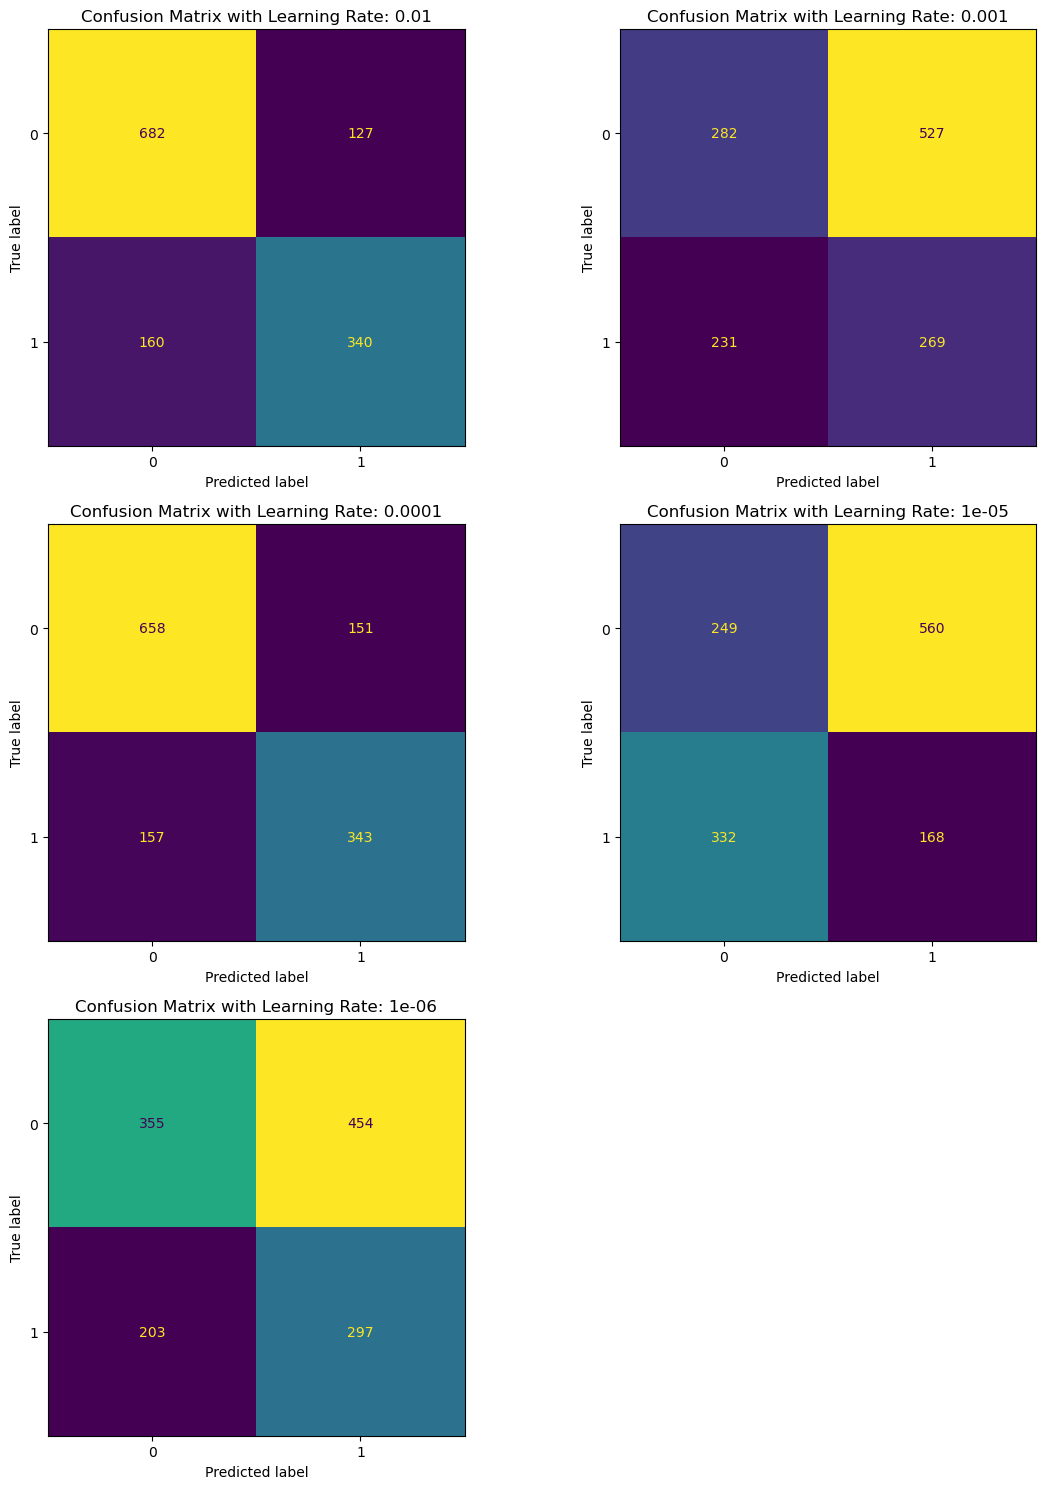

In [120]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print(confusion_metrics)
num_matrices = len(confusion_metrics)
ncols = 2  
nrows = (num_matrices + ncols - 1) // ncols  
fig, ax = plt.subplots(nrows, ncols, figsize=(12, nrows * 5))
ax = ax.flatten()
for idx, m in enumerate(confusion_metrics):
    conf_matrix, lr = m
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(ax=ax[idx], colorbar=False)
    ax[idx].set_title(f'Confusion Matrix with Learning Rate: {lr}')
for i in range(len(confusion_metrics), len(ax)):
    fig.delaxes(ax[i])
plt.tight_layout()
plt.show()

Confusion matrix for learning rate 0.01:
 [[282 527]
 [300 200]]
Training completed for learning rate: 0.01


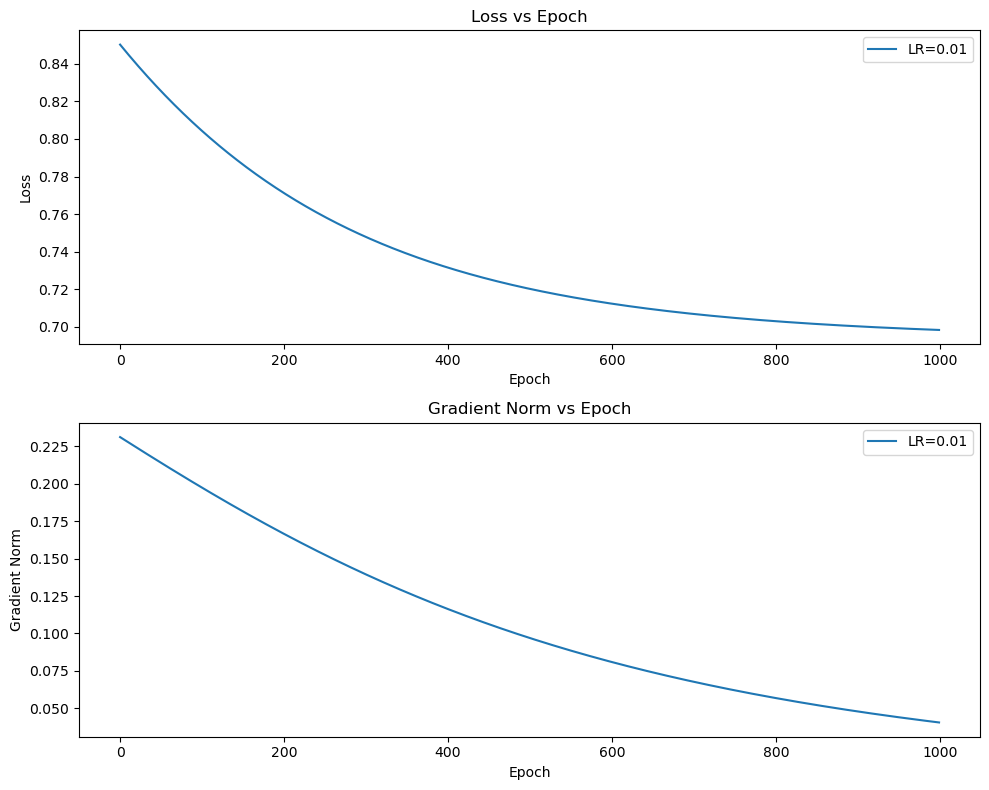

In [137]:
## ---- END of Q1 ----
import pandas as pd
import torch
from torch import Tensor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load and preprocess the data
titanic = pd.read_csv('/Users/giovannimaya/Downloads/TitanicSurvival.csv')
titanic['age'].fillna(titanic['age'].mean(), inplace=True)

sex_encoder = LabelEncoder()
passenger_encoder = LabelEncoder()
survived_encoder = LabelEncoder()

titanic['sex'] = sex_encoder.fit_transform(titanic['sex'])
titanic['passengerClass'] = passenger_encoder.fit_transform(titanic['passengerClass'])
titanic['survived'] = survived_encoder.fit_transform(titanic['survived'])


predictors = ['sex', 'age', 'passengerClass']
titanic[predictors] = titanic[predictors].apply(lambda x: (x - x.mean()) / x.std())

# Convert to torch tensors
feats = torch.tensor(titanic[predictors].values, dtype=torch.float32)
target = torch.tensor(titanic['survived'].values, dtype=torch.float32)

# Define the forward pass and loss function
def forward_pass(X: Tensor, weights: Tensor) -> Tensor:
    return torch.sigmoid(torch.matmul(X, weights))

def cross_entropy_loss(y_hat: Tensor, y: Tensor) -> Tensor:
    epsilon = 1e-7
    return -torch.mean(y * torch.log(y_hat + epsilon) + (1 - y) * torch.log(1 - y_hat + epsilon))

# Training function
def train_model(X: Tensor, y: Tensor, learning_rates, epochs=1000):
    metrics = {}
    
    for lr in learning_rates:
        weights = torch.randn(3, 1, requires_grad=True)
        
        losses = []
        gradient_history = []
        
        for epoch in range(epochs):
            y_hat = forward_pass(X, weights)  # forward pass
            loss = cross_entropy_loss(y_hat, y)  # calculate loss
            losses.append(loss.item())
            loss.backward()  # backward pass
            
            with torch.no_grad():
                weights -= lr * weights.grad  # update weight using gradient descent
                gradient_history.append(weights.grad.norm().item())  # store gradient norm
                weights.grad.zero_()
        
        final_predictions = forward_pass(X, weights)
        predicted_classes = torch.round(final_predictions).detach()
        metrics[lr] = (losses, gradient_history)
        
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(y.numpy(), predicted_classes.numpy())
        print(f"Confusion matrix for learning rate {lr}:\n", conf_matrix)
        print(f"Training completed for learning rate: {lr}")
    
    return weights, metrics

# Define learning rates and train the model
# learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
learning_rates = [1e-2]
final_weights, training_metrics = train_model(feats, target, learning_rates)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for lr, (losses, gradients) in training_metrics.items():
    ax[0].plot(losses, label=f"LR={lr}")
    ax[1].plot(gradients, label=f"LR={lr}")

ax[0].set_title('Loss vs Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Gradient Norm vs Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Gradient Norm')
ax[1].legend()

plt.tight_layout()
plt.show()


In [139]:
from sklearn.preprocessing import StandardScaler
recipes = pd.read_csv('/Users/giovannimaya/Downloads/epi_r-1 (1).csv')
target = recipes['cake']
feats = recipes.drop(columns=['cake'])
numeric_cols = feats.select_dtypes(include=['number']).columns
means = feats[numeric_cols].mean()
titles = feats['title']
feats = feats[numeric_cols].fillna(means)
feats[numeric_cols] = feats[numeric_cols].apply(lambda x: (x - x.mean()) / x.std())
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(feats)
tensor_data = torch.tensor(numeric_data_scaled, dtype=torch.float32)
target_data = torch.tensor(target.values, dtype=torch.float32)
tensor_data, target_data

(tensor([[-0.9058, -0.0184, -0.0205,  ..., -0.0374, -0.0308,  6.5554],
         [ 0.4926, -0.0185, -0.0240,  ..., -0.0374, -0.0308, -0.1525],
         [ 0.0265, -0.0192, -0.0275,  ..., -0.0374, -0.0308, -0.1525],
         ...,
         [ 0.4926, -0.0180, -0.0202,  ..., -0.0374, -0.0308,  6.5554],
         [ 0.4926, -0.0178, -0.0161,  ..., -0.0374, -0.0308, -0.1525],
         [ 0.4926, -0.0180, -0.0079,  ..., -0.0374, -0.0308, -0.1525]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, input_size, encoding_dim=10):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),  
            nn.ReLU(True),
            nn.Linear(128, 64),          
            nn.ReLU(True),
            nn.Linear(64, encoding_dim)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),  
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded 

In [141]:
input_size = feats.shape[1]
model = AutoEncoder(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [142]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

dataset = TensorDataset(tensor_data, target_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
loss_history = []
num_epochs = 100 

for epoch in range(num_epochs):
    for data in dataloader:
        inputs = data[0]
        encoded, decoded = model(inputs) 
        loss = criterion(decoded, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.8712
Epoch [20/100], Loss: 0.8110
Epoch [30/100], Loss: 1.4251
Epoch [40/100], Loss: 0.5976
Epoch [50/100], Loss: 0.5032
Epoch [60/100], Loss: 0.7370
Epoch [70/100], Loss: 0.5378
Epoch [80/100], Loss: 1.3365
Epoch [90/100], Loss: 0.7237
Epoch [100/100], Loss: 1.6521


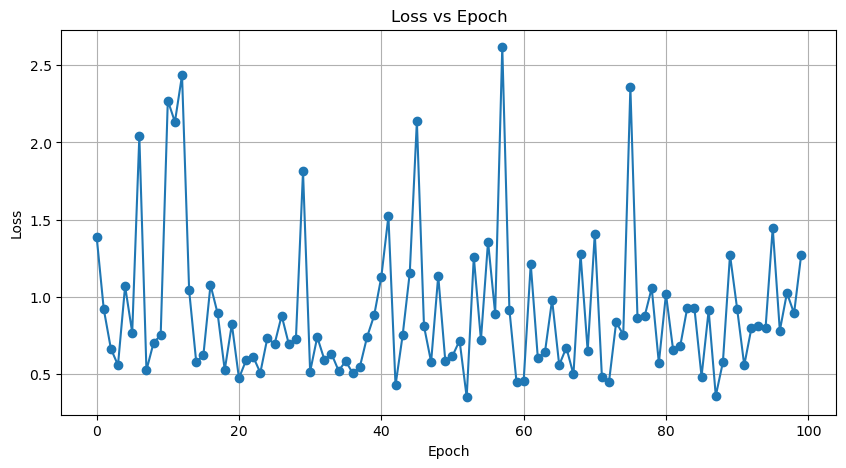

In [129]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_history, marker='o')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

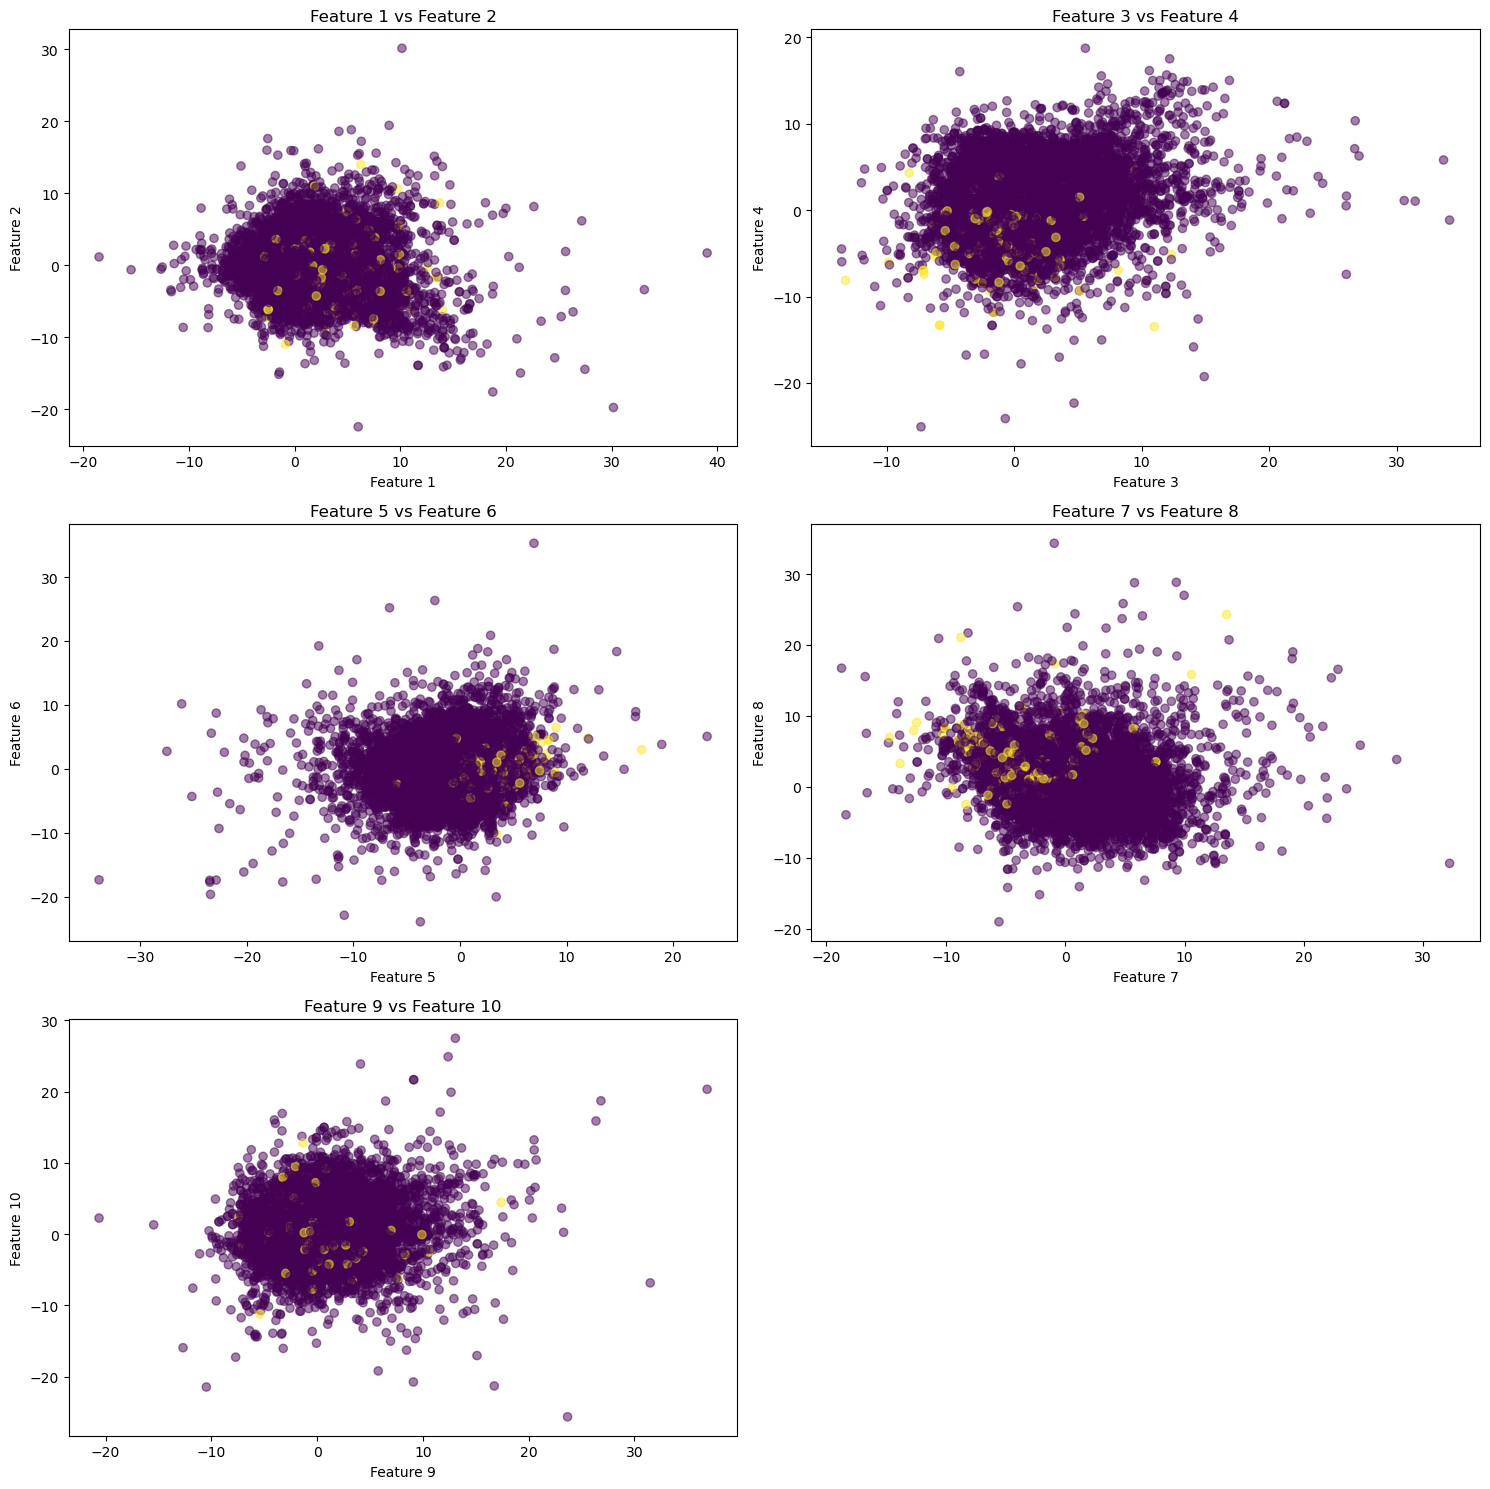

In [341]:
encoded_samples = []
labels = []
for data in dataloader:
    inputs, targets = data
    encoded, _ = model(inputs)
    encoded_samples.append(encoded.detach())
    labels.append(targets)
encoded_samples = torch.cat(encoded_samples, dim=0)
labels = torch.cat(labels, dim=0)
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()  
cmap = plt.get_cmap("viridis")
for i in range(5):
    ax = axes[i]
    x_idx = 2 * i
    y_idx = 2 * i + 1
    ax.scatter(encoded_samples[:, x_idx], encoded_samples[:, y_idx], c=labels.numpy(), alpha=0.5)
    ax.set_xlabel(f'Feature {x_idx+1}')
    ax.set_ylabel(f'Feature {y_idx+1}')
    ax.set_title(f'Feature {x_idx+1} vs Feature {y_idx+1}')
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

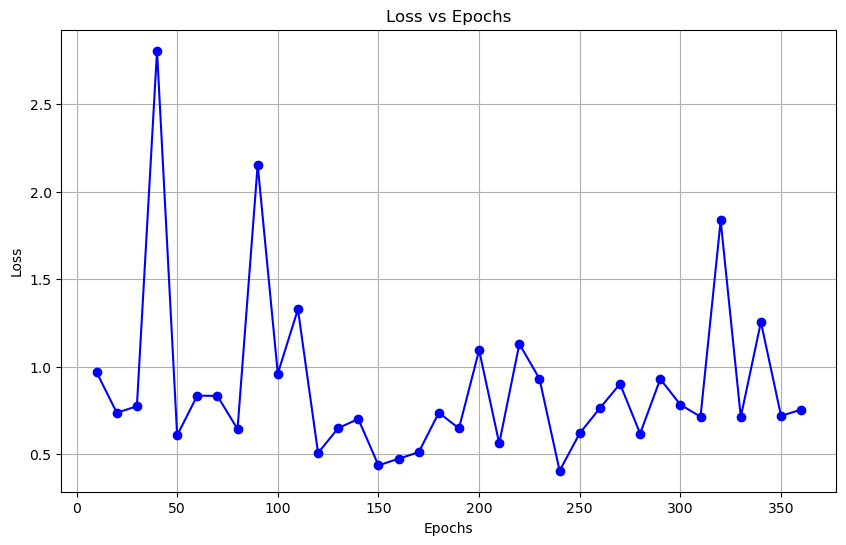

In [143]:
import matplotlib.pyplot as plt

# Loss values provided
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 
          210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]
losses = [0.9682, 0.7373, 0.7743, 2.8063, 0.6080, 0.8352, 0.8332, 0.6439, 2.1547, 0.9612, 
          1.3286, 0.5074, 0.6494, 0.7016, 0.4365, 0.4744, 0.5117, 0.7375, 0.6478, 1.0951, 
          0.5619, 1.1306, 0.9312, 0.4059, 0.6200, 0.7633, 0.9022, 0.6182, 0.9298, 0.7833, 
          0.7145, 1.8361, 0.7131, 1.2556, 0.7193, 0.7551]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
